# GloFAS Seasonal Forecast

In [1]:
import climetlab as cml
import climetlab_cems_flood as cmf
import matplotlib.pyplot as plt
import datetime
import geopandas as gpd
import pandas as pd
from climetlab_cems_flood.utils import get_po_basin

In [2]:
# pontelagoscuro
ps = (44.886111, 11.604444)
cm = ( 45.142222,8.447500) # casale monferrato po
ca = (45.576944, 9.534722) # canonica d'adda

In [3]:
gdf = get_po_basin()

ERROR 1: PROJ: proj_create_from_database: Open of /home/iacopo/.local/build/mambaforge/envs/cems/share/proj failed


<AxesSubplot: >

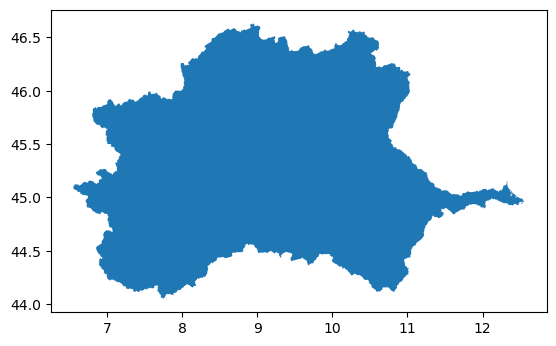

In [4]:
gdf_diss = gdf.dissolve()
gdf_diss.plot()

In [ ]:
minx, miny, maxx, maxy = gdf.unary_union.bounds

nwse = [maxy, minx,miny, maxx] 

In [7]:
seasonal = cml.load_dataset(
            'glofas-seasonal',
            model='lisflood',
            system_version='operational',
            temporal_filter= '2022 01-08 *',#'20220101-20220801',#'2001-200401-04*',
            leadtime_hour = '24-3600',
            variable="river_discharge_in_the_last_24_hours",
            area= nwse,
            split_on=["month"],
            merger=None
)

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/ecmwf-lab/climetlab_cems_flood/LICENSEIf you do not agree with such terms, do not download the data. 


In [19]:
seasonal

Home page,-
Documentation,-
Citation,-
Licence,-


In [20]:
water_balance = cml.load_dataset(
            'cems-flood-glofas-historical',
            model='lisflood',
            product_type='intermediate',
            system_version='version_3_1',
            period= '20220101-20220812',
            variable="river_discharge_in_the_last_24_hours",
            area= nwse,
            # split_on = ['hmonth'],
            threads = 6,
            merger=None
        )

By downloading data from this dataset, you agree to the terms and conditions defined at https://github.com/ecmwf-lab/climetlab_cems_flood/LICENSEIf you do not agree with such terms, do not download the data. 


In [22]:
water_2003 = cml.load_dataset(
            'cems-flood-glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            period= '20030101-20030812',
            variable="river_discharge_in_the_last_24_hours",
            area= nwse,
            # split_on = ['hmonth'],
            threads = 6,
            merger= None
        )

In [23]:
climatology_2000_2021 = cml.load_dataset(
            'cems-flood-glofas-historical',
            model='lisflood',
            product_type='consolidated',
            system_version='version_3_1',
            period= '2000-202101-10*',
            variable="river_discharge_in_the_last_24_hours",
            area= nwse,
            split_on = ['hyear','hmonth'],
            threads = 10,
            merger=None
        )

In [ ]:
seas = seasonal.to_xarray()
wb = water_balance.to_xarray()
cl = climatology_2000_2021.to_xarray()

In [ ]:
wb

In [ ]:
wb_2003 = water_2003.to_xarray()

In [ ]:
wb_2003

In [74]:
wb_2003 = wb_2003.sel(time=slice("2003-01-01","2003-08-13"))
wb_2003.dis24.shape

(225, 27, 61)

In [75]:
wb_2003["time"] = wb["time"]

In [76]:
cl = cl.chunk({"time":500})
cmean = cl.groupby("time.dayofyear").mean()
cmin = cl.groupby("time.dayofyear").min()
cmax = cl.groupby("time.dayofyear").max()

In [77]:
cmax = cmax.where(cmax.dayofyear != cmax.dayofyear[59], drop =True)

In [78]:
cmin = cmin.where(cmin.dayofyear != cmin.dayofyear[59], drop =True)

In [79]:
cmean = cmean.where(cmean.dayofyear != cmean.dayofyear[59], drop =True)

In [80]:
# seas = seas.rio.write_crs("EPSG:4326")
# cmean = cmean.rio.write_crs("EPSG:4326")
# wb = wb.rio.write_crs("EPSG:4326")

In [81]:
# seas = seas.rio.clip(gdf_diss.geometry)
# wb = wb.rio.clip(gdf_diss.geometry)
# cmean = cmean.rio.clip(gdf_diss.geometry)

In [82]:
cmean["time"] =  pd.date_range("2022-01-01","2022-10-31")
cmin["time"]=  pd.date_range("2022-01-01","2022-10-31")
cmax["time"] =  pd.date_range("2022-01-01","2022-10-31")

In [66]:
# plt.figure(figsize=(20,10))
# seas.dis24.isel(realization=0,leadtime=0,forecast_reference_time=0).plot()
# plt.scatter(ps[1],ps[0],s=10,color="red")

In [42]:
seas = seas.sel(lat=ps[0],lon=ps[1],method="nearest")

cmean = cmean.sel(latitude=ps[0],longitude=ps[1],method="nearest")

cmax= cmax.sel(latitude=ps[0],longitude=ps[1],method="nearest")

cmin = cmin.sel(latitude=ps[0],longitude=ps[1],method="nearest")

wb = wb.sel(latitude=ps[0],longitude=ps[1],method="nearest")

wb_2003 = wb_2003.sel(latitude=ps[0],longitude=ps[1],method="nearest")

/home/iacopo/.pyenv/versions/riverv-dev/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/iacopo/.pyenv/versions/riverv-dev/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


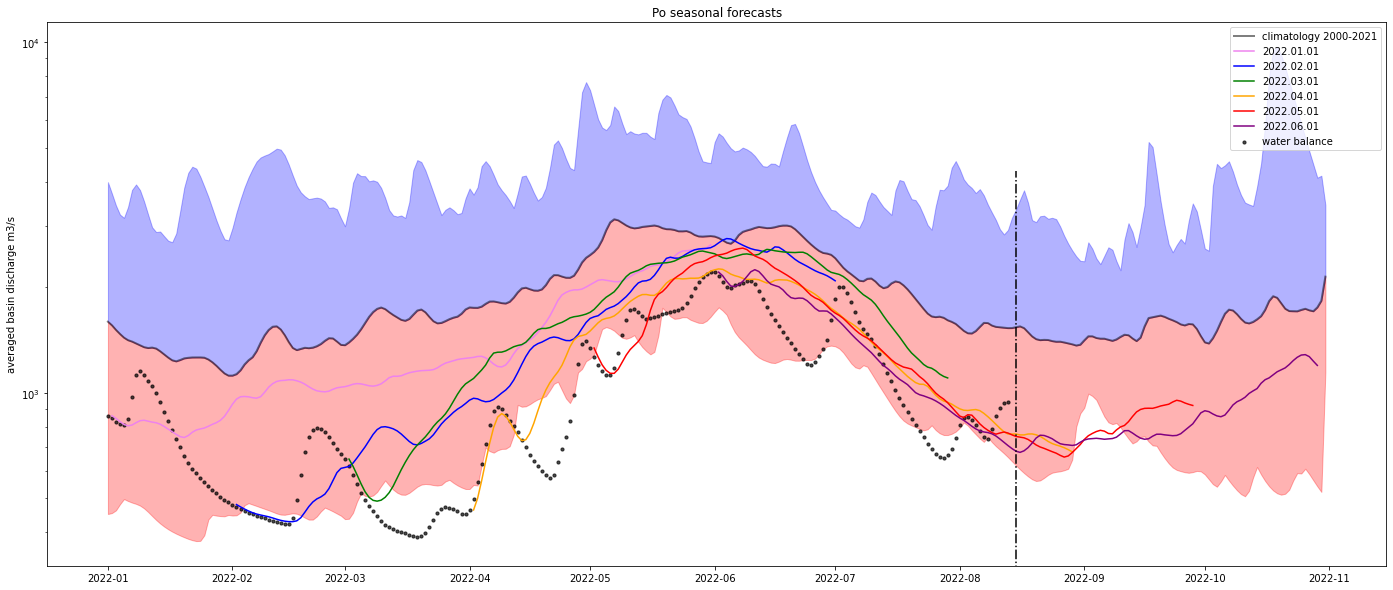

In [50]:
plt.figure(figsize=(24,10))

plt.fill_between(cmin.time.values,cmean.dis24.values.T,cmax.dis24.values.T,color="blue",alpha=0.3)
plt.fill_between(cmin.time.values,cmin.dis24.values.T,cmean.dis24.values.T,color="red",alpha=0.3)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=2, color="black",label = "climatology 2000-2021", alpha=0.5)

for i,c in enumerate(["violet","blue","green","orange","red","purple"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
# plt.scatter(wb_2003.time.values,wb_2003.dis24.values.T,color="red",s=12, label="water balance 2003", alpha=0.7)
plt.vlines(x=datetime.datetime(2022,8,15),ymin=0,ymax=4300,linestyle="-.", color="black")
plt.legend()
plt.ylabel("averaged basin discharge m3/s") 
plt.title("Po seasonal forecasts")
plt.yscale("log")

In [67]:
seas = seas.sel(lat=cm[0],lon=cm[1],method="nearest")

cmean = cmean.sel(latitude=cm[0],longitude=cm[1],method="nearest")

cmax= cmax.sel(latitude=cm[0],longitude=cm[1],method="nearest")

cmin = cmin.sel(latitude=cm[0],longitude=cm[1],method="nearest")

wb = wb.sel(latitude=cm[0],longitude=cm[1],method="nearest")

wb_2003 = wb_2003.sel(latitude=cm[0],longitude=cm[1],method="nearest")

/home/iacopo/.pyenv/versions/riverv-dev/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/iacopo/.pyenv/versions/riverv-dev/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


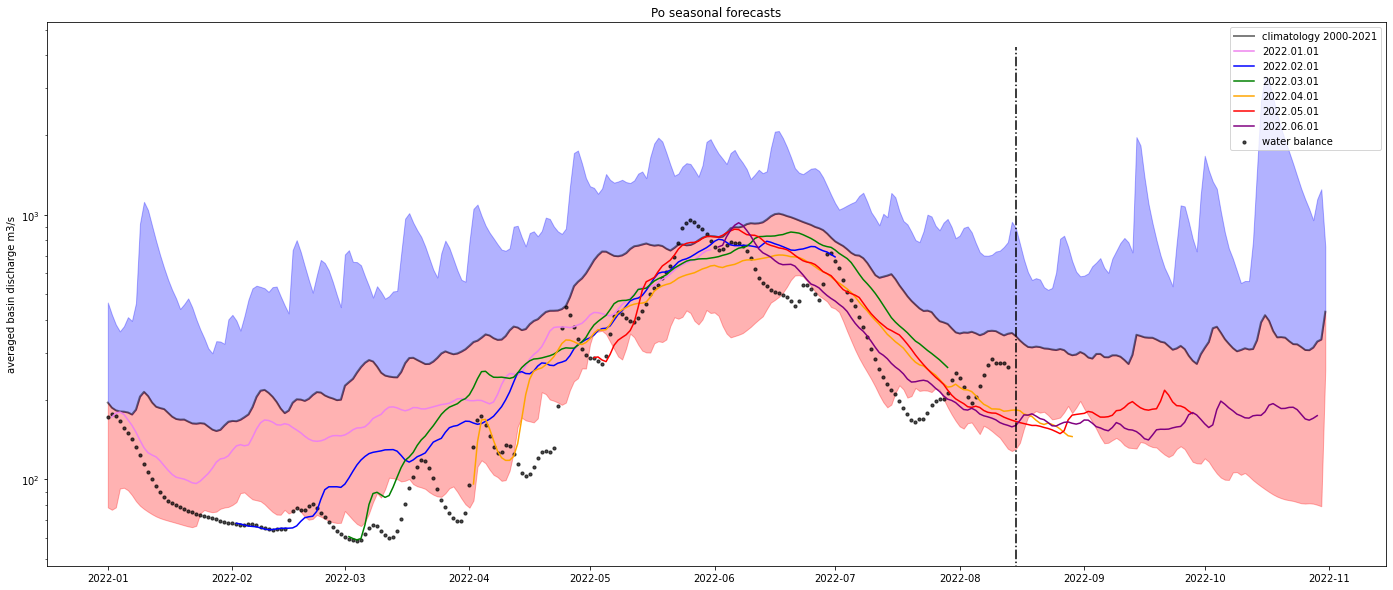

In [68]:
plt.figure(figsize=(24,10))

plt.fill_between(cmin.time.values,cmean.dis24.values.T,cmax.dis24.values.T,color="blue",alpha=0.3)
plt.fill_between(cmin.time.values,cmin.dis24.values.T,cmean.dis24.values.T,color="red",alpha=0.3)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=2, color="black",label = "climatology 2000-2021", alpha=0.5)

for i,c in enumerate(["violet","blue","green","orange","red","purple"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
# plt.scatter(wb_2003.time.values,wb_2003.dis24.values.T,color="red",s=12, label="water balance 2003", alpha=0.7)
plt.vlines(x=datetime.datetime(2022,8,15),ymin=0,ymax=4300,linestyle="-.", color="black")
plt.legend()
plt.ylabel("averaged basin discharge m3/s") 
plt.title("Po seasonal forecasts")
plt.yscale("log")

In [83]:
seas = seas.sel(lat=ca[0],lon=ca[1],method="nearest")

cmean = cmean.sel(latitude=ca[0],longitude=ca[1],method="nearest")

cmax= cmax.sel(latitude=ca[0],longitude=ca[1],method="nearest")

cmin = cmin.sel(latitude=ca[0],longitude=ca[1],method="nearest")

wb = wb.sel(latitude=ca[0],longitude=ca[1],method="nearest")

wb_2003 = wb_2003.sel(latitude=ca[0],longitude=ca[1],method="nearest")

/home/iacopo/.pyenv/versions/riverv-dev/lib/python3.10/site-packages/dask/array/reductions.py:608: RuntimeWarning: All-NaN slice encountered
  return np.nanmax(x_chunk, axis=axis, keepdims=keepdims)
/home/iacopo/.pyenv/versions/riverv-dev/lib/python3.10/site-packages/dask/array/reductions.py:579: RuntimeWarning: All-NaN slice encountered
  return np.nanmin(x_chunk, axis=axis, keepdims=keepdims)


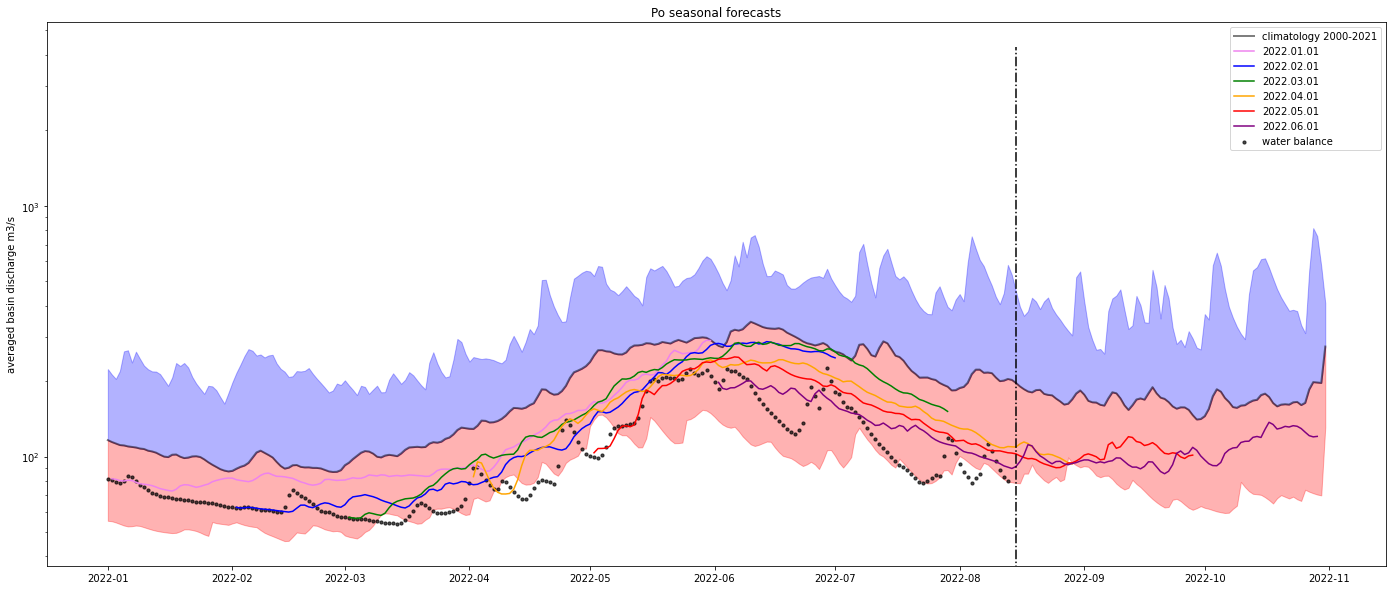

In [84]:
plt.figure(figsize=(24,10))

plt.fill_between(cmin.time.values,cmean.dis24.values.T,cmax.dis24.values.T,color="blue",alpha=0.3)
plt.fill_between(cmin.time.values,cmin.dis24.values.T,cmean.dis24.values.T,color="red",alpha=0.3)
plt.plot(cmean.time.values,cmean.dis24.values.T, linewidth=2, color="black",label = "climatology 2000-2021", alpha=0.5)

for i,c in enumerate(["violet","blue","green","orange","red","purple"]):
    t = seas.dis24.forecast_reference_time[i].values
    t = pd.to_datetime(t).strftime('%Y.%m.%d')
    m = seas.dis24.isel(forecast_reference_time=i,drop=True)
    plt.plot(m.time.values, m.mean("realization").values.T,color=c, label=t)
plt.scatter(wb.time.values,wb.dis24.values.T,color="black",s=10, label="water balance", alpha=0.7)
# plt.scatter(wb_2003.time.values,wb_2003.dis24.values.T,color="red",s=12, label="water balance 2003", alpha=0.7)
plt.vlines(x=datetime.datetime(2022,8,15),ymin=0,ymax=4300,linestyle="-.", color="black")
plt.legend()
plt.ylabel("averaged basin discharge m3/s") 
plt.title("Po seasonal forecasts")
plt.yscale("log")